# Work - The Prediction of Voltage at the Pantograph for Passenger Trains

## 1. Introduction

## The topics of the Work

The work includes the topic for the common topic of data science, covering:

1.	Exploratory Data Analysis
2.	The Use of Random Forest Regressor
3.	The Use of Feature Importance
4.	The Use of Randomized Search for Random Forest
5.	The Use of Randomized Search for XG Boost
6.	The Use of Randomized Search for LightGBM
7.	Reference

The result of best score for Random Forest, XG Boost and LightXGM are **0.857**, **0.849** and **0.847** respectively.

In [2]:
import re
import sys
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
import statsmodels.api as sm
import sklearn.model_selection as ms
from sklearn import neighbors
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score, ShuffleSplit
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,classification_report,roc_auc_score, roc_curve, accuracy_score, f1_score
from IPython.display import display

from xgboost import XGBClassifier
from xgboost import XGBRegressor 
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor 

localtime = time.asctime( time.localtime(time.time()) )
timeshow =  time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 


In [3]:
database = pd.read_csv(r"C:\Users\Anson\OneDrive\Anson File\PythonApplication_anson\3_Kaggle\5_LRT3 Traction Power Loading\Course_LRTIII_DN_Course_15.csv")
database.drop(labels = 0, axis='index', inplace=True)

In [4]:
database.info()
print('database\n\n',database)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 14938 entries, 1 to 14938
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   t_abs                    14938 non-null  object 
 1   Course                   11898 non-null  float64
 2   t_rel                    14938 non-null  object 
 3   networkName              14938 non-null  object 
 4   lineID                   14938 non-null  object 
 5   trackID                  14938 non-null  object 
 6   linePosition             14938 non-null  object 
 7   corrPosition             14938 non-null  object 
 8   distance                 14938 non-null  object 
 9   m                        14938 non-null  object 
 10  v                        14938 non-null  object 
 11  delay                    14938 non-null  object 
 12  F_req                    14938 non-null  object 
 13  F_ach                    14938 non-null  object 
 14  F_Propulsion          

## 2. Data Encoding for the Text

## 2. Data Cleaning and Manipulation

In [5]:
features = ['linePosition','v','F_Propulsion','eta_Panto','P_Panto','Phi_Panto','P_mech','|U_Panto|']

database['linePosition'] = database['linePosition'].apply(lambda x : x.replace('+', '.'))
database['P_Panto'] = database['P_Panto'].apply(lambda x : x.replace(',', ''))
database['P_mech'] = database['P_mech'].apply(lambda x : x.replace(',', ''))


database[features]=database[features].astype(np.float64)
database[features].fillna(database[features].mean(), inplace=True)
database[features].drop(database.index[0],axis=0,inplace=True)

database[features] = np.nan_to_num(database[features])


print('database[features].dtypes)',database[features].dtypes)
# print('np.isnan(database[features])',np.isnan(database[features]))

database[features].dtypes) linePosition    float64
v               float64
F_Propulsion    float64
eta_Panto       float64
P_Panto         float64
Phi_Panto       float64
P_mech          float64
|U_Panto|       float64
dtype: object


C:\Users\Anson\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Anson\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 3. Exploratory Data Analysis

### a) Scatter Plat of linePosition and v


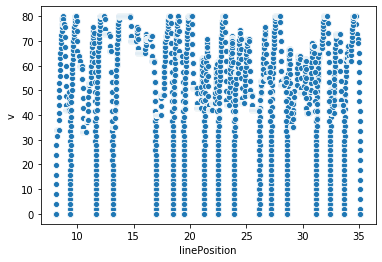

In [6]:
sns.scatterplot( x=database['linePosition'], y=database['v'])
plt.show()

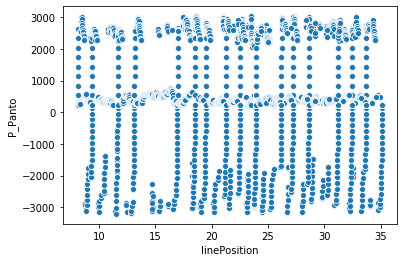

In [7]:
sns.scatterplot( x=database['linePosition'], y=database['P_Panto'])
plt.show()

### c) Distribution of Age vs Annual Premium

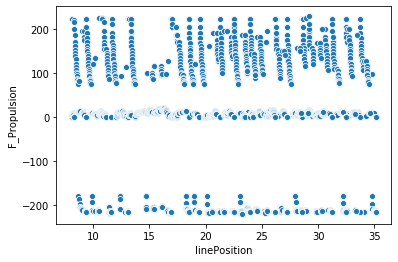

In [8]:
sns.scatterplot( x=database['linePosition'], y=database['F_Propulsion'])
plt.show()

## 5. Correlation Matrix

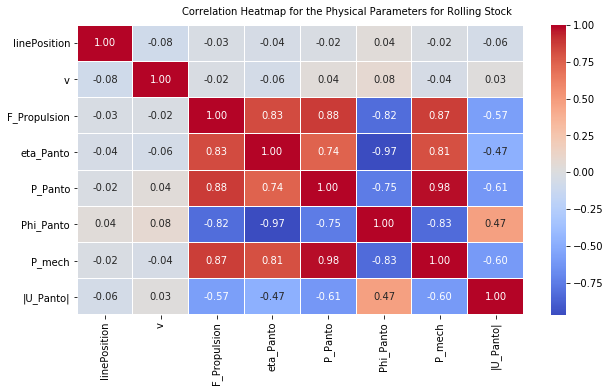

In [9]:
corr_database=database[features].corr()
corr_database=corr_database.round(2)


f, ax = plt.subplots(figsize=(10, 5))
hm = sns.heatmap(corr_database, annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap for the Physical Parameters for Rolling Stock', fontsize=10)
plt.show()

In [10]:
# features = ['linePosition','v','F_Propulsion','eta_Panto','P_Panto','Phi_Panto','P_mech','|U_Panto|']
features_X = ['linePosition','v','F_Propulsion','eta_Panto','P_Panto','Phi_Panto','P_mech']
features_y = ['|U_Panto|']

shuffled_database = database.reindex(np.random.permutation(database.index))
shuffled_database[features]=shuffled_database[features]
X = shuffled_database[features_X]
y = shuffled_database[features_y]


## 7. Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)


## 8.The Use of Random Forest Regressor

In [12]:
RF_Regressor= RandomForestRegressor(n_estimators = 500, max_depth= 100, random_state=20)
RF_Regressor.fit(X_train,y_train)
y_RF_pred=RF_Regressor.predict(X_test)
RF_Regressor_score=RF_Regressor.score(X_test,y_test)

print('RF_Regressor_score',RF_Regressor_score.round(3))

C:\Users\Anson\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RF_Regressor_score 0.857


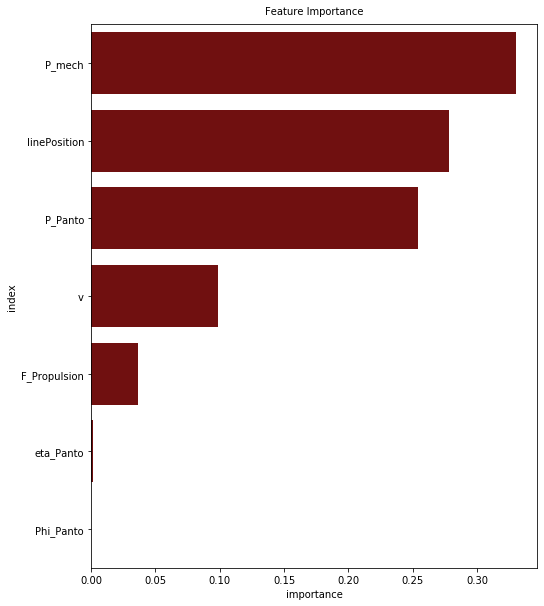

In [13]:
RF_feature_importances=RF_Regressor.feature_importances_

feature_importances = pd.DataFrame(RF_feature_importances,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)


fig, ax = plt.subplots(1,1, figsize=(8,10))
sns.barplot(x='importance', y='index', color='#800000',data=feature_importances.reset_index());
plt.title('Feature Importance', fontsize=10, pad=10)
plt.show();


In [14]:
score_CV_RF_Regressor = cross_val_score(RF_Regressor,X,y.values.ravel(),cv=5 )
print("with CV RF_Classifier=", score_CV_RF_Regressor.mean().round(3))



with CV RF_Classifier= 0.856


In [15]:
param_grid_RF={ 
    'n_estimators'  : [50,100,200,300,500,700,1000]                                       ,
    'max_depth'     : [10,11,15,20,25,50,100,150,200,300,500]                             ,
    'max_features'  : ['auto','sqrt', 'log2']                                             ,
}

param_grid_XGBoost={ 
    'n_estimators'  : [15,25,50,100,200,300,500,700,1000]              ,
    'learning_rate' : [0.1, 0.3, 0.5,1,3,5]                            ,
    'max_depth'     : [10,20,50,100,200,500]                           , 
}

param_grid_LightGBM={ 
    'num_leaves'  : [15,25,50,100,200,300,500,700,1000]   , 
    'min_child_samples':[5,10,15]                         ,               
    'learning_rate' : [0.1, 0.3, 0.5,1,3,5]               ,
    'max_depth'     : [5,10,15,20,40,70]                  ,
    'reg_alpha':[0,0.01,0.03]                             , 
}

## 10. Randomized Search for Random Forest

In [16]:
Randomized_Search_rfr=RandomizedSearchCV(RF_Regressor, param_distributions = param_grid_RF, cv=5)
Randomized_Search_rfr.fit(X_train,y_train.values.ravel())

print("Randomized_Search.Best_params_",Randomized_Search_rfr.best_params_)
print("Randomized_Search.Best_score_",Randomized_Search_rfr.best_score_.round(3))


Randomized_Search.Best_params_ {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 300}
Randomized_Search.Best_score_ 0.851


## 11. Randomized Search for XG Boost

In [24]:
XGBoost_Regressor = XGBRegressor()
Randomized_Search_XGBoost=RandomizedSearchCV(XGBoost_Regressor, param_distributions = param_grid_XGBoost, cv=5)

Randomized_Search_XGBoost.fit(X_train,y_train.values.ravel())

print("Randomized_Search for XGBoost_Best_estimator_",Randomized_Search_XGBoost.best_estimator_)
print("Randomized_Search for XGBoost_Best_params_",Randomized_Search_XGBoost.best_params_)
print("Randomized_Search for XGBoost.Best_score_",Randomized_Search_XGBoost.best_score_.round(3))

Randomized_Search for XGBoost_Best_estimator_ XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Randomized_Search for XGBoost_Best_params_ {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}
Randomized_Search for XGBoost.Best_score_ 0.849


## 12. Randomized Search for LightGBM

In [18]:
LightGBM_Regressor = LGBMRegressor() 
Randomized_Search_LightGBM=RandomizedSearchCV(LightGBM_Regressor, param_distributions = param_grid_LightGBM, cv=5)
Randomized_Search_LightGBM.fit(X_train,y_train.values.ravel())

print("Randomized_Search for LightGBM_Best_estimator_",Randomized_Search_LightGBM.best_estimator_)
print("Randomized_Search for LightGBM_Best_params_",Randomized_Search_LightGBM.best_params_)
print("Randomized_Search for LightGBM.Best_score_",Randomized_Search_LightGBM.best_score_.round(3))

Randomized_Search for LightGBM_Best_estimator_ LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=300, objective=None,
              random_state=None, reg_alpha=0.01, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Randomized_Search for LightGBM_Best_params_ {'reg_alpha': 0.01, 'num_leaves': 300, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.1}
Randomized_Search for LightGBM.Best_score_ 0.847


## 13. Improvement after the Previous Assessment
### 13a. New Features Selection after Feature Importnace and 
Same setting will be performed, except for the number of features selected.
The features are selected and listed below: 
1. linePosition 
2. v 
3. F_Propulsion 
4. P_Panto 

In [19]:
features_new = ['linePosition','v','F_Propulsion','P_Panto']

X_new = shuffled_database[features_new]
y_new = shuffled_database[features_y]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.20, random_state=20)

RF_Regressor_new= RandomForestRegressor(n_estimators = 500, max_depth= 100, random_state=20)
RF_Regressor_new.fit(X_train_new,y_train_new.values.ravel())
y_RF_pred_new=RF_Regressor_new.predict(X_test_new)
RF_Regressor_score_new=RF_Regressor_new.score(X_test_new,y_test_new)

print('RF_Classifier_score_new',RF_Regressor_score_new.round(3))
print('RF_Classifier_score_previous',RF_Regressor_score_new.round(3))

RF_Classifier_score_new 0.857
RF_Classifier_score_previous 0.857


## 14. Save the Estimator, Hyperparameter in the File

In [20]:
filename_Best_estimator = 'XG_Boost_Best_estimator.sav'
filename_Best_params = 'XG_Boost_Best_params.sav'
filename_Best_score = 'XG_Boost_Best_score.sav'

#pickle.dump(Randomized_Search_XGBoost.best_estimator_, open(filename_Best_estimator, 'wb'))
#pickle.dump(Randomized_Search_XGBoost.best_params_, open(filename_Best_params, 'wb'))
#pickle.dump(Randomized_Search_XGBoost.best_score_, open(filename_Best_score, 'wb'))